In [1]:
import torch
from basic_unet import UNet
from dataset import load_dataset
from plot_utils import plot_image_row
from hausdorff_distance_masks import HausdorffDistanceMasks

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = load_dataset(batch_size=1)
model = UNet(in_channels=4, out_channels=1)
state_dict = torch.load('models/3_basic_unet_flat_criterion_279_0.00000.pth')
model.load_state_dict(state_dict)
model = model.to(device)

In [3]:
sample = next(iter(test_loader))
segment = sample['segment']
segment = segment.squeeze()

image = sample['input']
image = image.to(device)

output = model(image)
output = output.detach().cpu().squeeze().numpy()

In [4]:
hdm = HausdorffDistanceMasks(240, 240)
hdm.generate_masks(circle_size=20, offset=5, normalize=True)

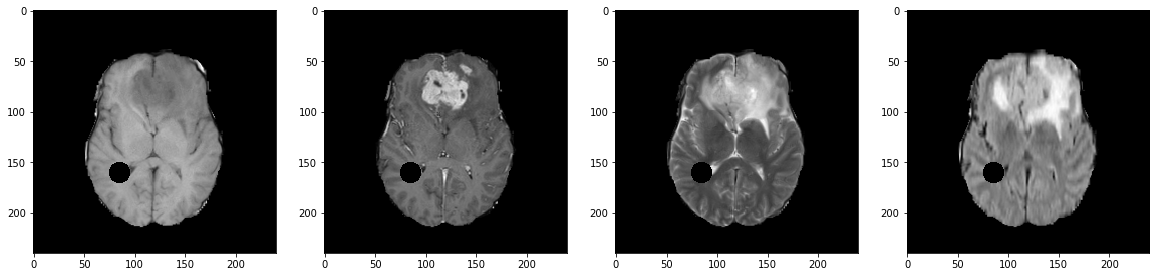

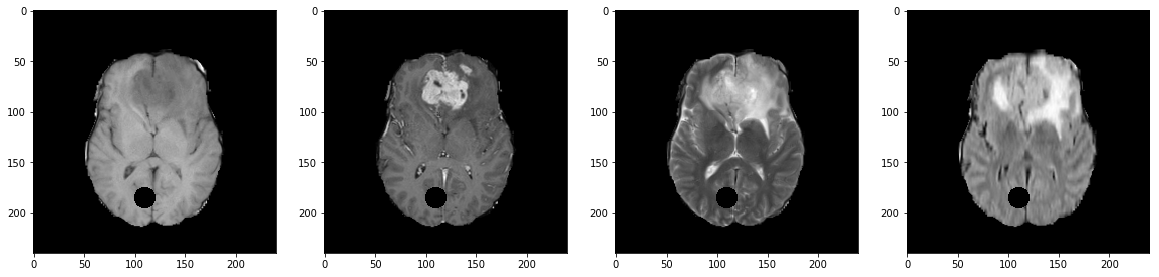

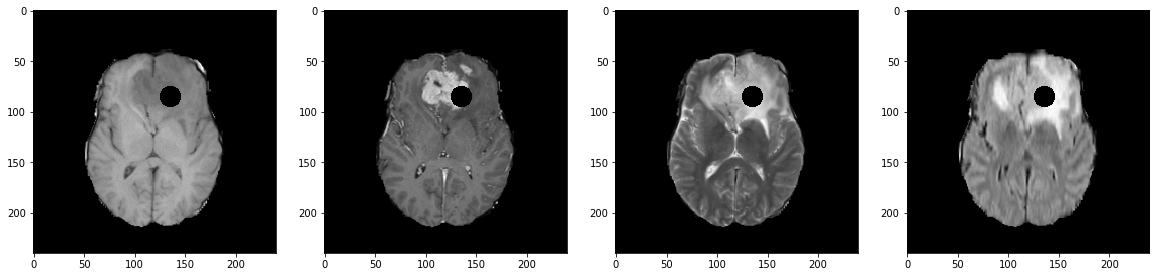

In [5]:
offsets = [
    (15, 30),
    (20, 35),
    (25, 15),
]
for y_offset, x_offset in offsets:
    mask = hdm.masks[x_offset][y_offset]
    mask = mask.to(device)
    masked_image = torch.min(image, mask)
    masked_image = masked_image.cpu()[0]
    plot_image_row([
        masked_image[0],
        masked_image[1],
        masked_image[2],
        masked_image[3]],
        color_map='gray')